# Outbrain Click Prediction Kaggle Competition

_Submitted by Jay Cordes, Sarah Kelly, Nicole Lee, and Lisa Minas_

## Problem Background and Modeling Plan

Outbrain is looking to predict which ad in a given display will be clicked by a user. They have provided an extensive amount of information about where an ad is displayed, what the ad is displaying, and user activity on multiple publisher sites in the United States between 14-June-2016 and 28-June-2016. Based on this information, we are asked to order by decending probability which ad within a display a user will click. 

We plan to approach this problem in a step-wise process. First, we will explore the data to better understand what information has been provided. Based on our initial investigation, we will transform the data to fit with the machine learning models we expect to be most appropriate for predicting clicks. If we find potential value in multiple models, we will quickly score a trained model on development data to determine which model we should focus on for optimization. Once a final model is chosen, we will further refine the model and judiciously score against the development model. Our final score will be determined by testing against a provided test dataset (clicks_test) and by the score judged via Kaggle.

Note: We are running this notebook in Python3 because Kaggle uses Python3.

# Data Loading

First we load all of the datasets and save them to files we will not overwrite. These files are very large and take a while to download. To avoid re-downloading multiple times through development, we found it easiest to create copies of the original files that we could re-refer to when needing to adjust our transformations.

Based on documentation, platform and traffic_source should be 1 of three values: 1, 2, 3. We discovered through EDA that these numbers came in as both ints and strs. To clean them up, we added a dtype statement to the read_csv below.

In [1]:
# importing general libraries
import pandas as pd
import numpy as np
import copy
from matplotlib import pyplot as plt

# importing ML libraries
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# importing visual analysis 
from IPython.display import Image

# # Other libraries from homework 2
# SK-learn libraries for learning.
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import BernoulliNB
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.grid_search import GridSearchCV

# # SK-learn libraries for evaluation.
# from sklearn.metrics import confusion_matrix
# from sklearn import metrics
# from sklearn.metrics import classification_report

# # SK-learn libraries for feature extraction from text.
# from sklearn.feature_extraction.text import *

In [4]:
# loading all of the files
clicks_train_og = pd.read_csv("../input/clicks_train.csv")
promoted_content_og = pd.read_csv("../input/promoted_content.csv")
doc_cats_og = pd.read_csv("../input/documents_categories.csv")
doc_ents_og = pd.read_csv("../input/documents_entities.csv")
doc_meta_og = pd.read_csv("../input/documents_meta.csv")
doc_topics_og = pd.read_csv("../input/documents_topics.csv")
events_og = pd.read_csv("../input/events.csv", dtype={'platform': str, 'geo_location': str})
page_views_og = pd.read_csv("../input/page_views_sample.csv", dtype={'platform': str, 'traffic_source': str, 'geo_location': str})
clicks_test_og = pd.read_csv("../input/clicks_test.csv")

## Data exploration

Size has turned into a major issue with this project. Outbrain provided 9 CSVs of data averaging over 100 MB in compressed form with one file that is over 2 billion rows and 100GB uncompressed. This file is so large, Outbrain provided a 10th file which is a smaller sample to use for development.

In [3]:
print("Clicks_train size is: {}".format(clicks_train_og.shape))
print("Clicks_test size is: {}".format(clicks_test_og.shape))
print("Promoted Content size is: {}".format(promoted_content_og.shape))
print("Document Categories size is: {}".format(doc_cats_og.shape))
print("Document Entities size is: {}".format(doc_ents_og.shape))
print("Document Meta size is: {}".format(doc_meta_og.shape))
print("Document Topics size is: {}".format(doc_topics_og.shape))
print("Events size is: {}".format(events_og.shape))
print("Page Views size is: {}".format(page_views_og.shape)) # note: full page views is ~100GB uncompressed

Clicks_train size is: (87141731, 3)
Clicks_test size is: (32225162, 2)
Promoted Content size is: (559583, 4)
Document Categories size is: (5481475, 3)
Document Entities size is: (5537552, 3)
Document Meta size is: (2999334, 4)
Document Topics size is: (11325960, 3)
Events size is: (23120126, 6)
Page Views size is: (9999999, 6)


First, let's explore what we're training on: clicks_train and clicks test.

In [4]:
print("Clicks_train:")
print(clicks_train_og.head())
print("\nClicks_test:")
print(clicks_test_og.head())

Clicks_train:
   display_id   ad_id  clicked
0           1   42337        0
1           1  139684        0
2           1  144739        1
3           1  156824        0
4           1  279295        0

Clicks_test:
   display_id   ad_id
0    16874594   66758
1    16874594  150083
2    16874594  162754
3    16874594  170392
4    16874594  172888


Note that test does not have the clicked label. To score our models as we build, we need to have a development set that we can predict and verify success against a known label. If we don't have a set-aside testing dataset, we'll likely overfit our model to the training data and have poorer results when scoring clicks_test and the hidden kaggle testind dataset. Therefore we will break the training data into training and development with a 70%-30% split. Otherwise, the two datasets look very similar. But display_id is the same for these first rows.

In [5]:
print(clicks_train_og[clicks_train_og.display_id < 4])

    display_id   ad_id  clicked
0            1   42337        0
1            1  139684        0
2            1  144739        1
3            1  156824        0
4            1  279295        0
5            1  296965        0
6            2  125211        0
7            2  156535        0
8            2  169564        0
9            2  308455        1
10           3   71547        0
11           3   95814        0
12           3  152141        0
13           3  183846        0
14           3  228657        1
15           3  250082        0


The first few display_ids show us that there's multiple ad_ids per display_id. Within each display_id grouping, only one ad_id is which is marked as checked. Can a single ad_id be in multiple display_ids?

In [5]:
print(clicks_train_og[clicks_train_og.ad_id == 250082]).head(20)

          display_id   ad_id  clicked
15                 3  250082        0
441               91  250082        0
550              112  250082        0
6297            1241  250082        0
7732            1526  250082        0
9539            1874  250082        0
11730           2299  250082        0
12850           2516  250082        0
14723           2878  250082        0
15398           3008  250082        0
17683           3446  250082        1
18346           3579  250082        0
19724           3839  250082        0
20174           3926  250082        0
21556           4196  250082        0
22733           4435  250082        0
28623           5566  250082        0
31803           6194  250082        0
32951           6427  250082        0
33462           6529  250082        0
35703           6962  250082        0
35892           6999  250082        0
38058           7436  250082        0
43151           8443  250082        0
46776           9151  250082        0
48661       

AttributeError: 'NoneType' object has no attribute 'head'

Yes, a single ad_id can appear in many different display_ids and each ad_id can be clicked on in multiple different display_ids. To learn more about any ad_id, Outbrain says to look into promoted content.

In [7]:
print(promoted_content_og.head())

   ad_id  document_id  campaign_id  advertiser_id
0      1         6614            1              7
1      2       471467            2              7
2      3         7692            3              7
3      4       471471            2              7
4      5       471472            2              7


Promoted content shows which campaign_id from which advertiser_id contains the ad_id. Each campaign_id can contain multiple ad_ids. Can an ad_id be related to multiple document_ids?

In [8]:
print("Are there multiple rows per ad?: {}".format(len(promoted_content_og['ad_id'].unique()) != len(promoted_content_og)))
print("Is each document related to only one ad?: {}".format(len(promoted_content_og['document_id'].unique()) == len(promoted_content_og)))

Are there multiple rows per ad?: False
Is each document related to only one ad?: False


What is a document? Outbrain says the document_X.csv files provide context on documents as well as Outbrain's confidence in each respective relationship.

In [9]:
print("Document Categories:")
print(doc_cats_og.head())
print("\nDocument Entities:")
print(doc_ents_og.head())
print("\nDocument Topics:")
print(doc_topics_og.head())
print("\nDocument Meta:")
print(doc_meta_og.head())

Document Categories:
   document_id  category_id  confidence_level
0      1595802         1611              0.92
1      1595802         1610              0.07
2      1524246         1807              0.92
3      1524246         1608              0.07
4      1617787         1807              0.92

Document Entities:
   document_id                         entity_id  confidence_level
0      1524246  f9eec25663db4cd83183f5c805186f16          0.672865
1      1524246  55ebcfbdaff1d6f60b3907151f38527a          0.399114
2      1524246  839907a972930b17b125eb0247898412          0.392096
3      1524246  04d8f9a1ad48f126d5806a9236872604          0.213996
4      1617787  612a1d17685a498aff4f036c1ee02c16          0.386193

Document Topics:
   document_id  topic_id  confidence_level
0      1595802       140          0.073113
1      1595802        16          0.059416
2      1595802       143          0.045421
3      1595802       170          0.038867
4      1524246       113          0.196450

Docu

So each document_id can be described by a list of category_ids, entity_ids, and topic_ids. Apparently Outbrain either doesn't fully know what is in each document_id or they judge a document is mostly defined by one aspect but has influences of another. As an example: if a document talks about Brad Pitt and refers to his ex-wife as Angelina, we can say the document is 80% about Brad Pitt and 20% about Angelina. Or, alternatively, they are 80% sure the words _Brad Pitt_ refers to the person Brad Pitt and 20% sure the words _Angelina_ refers to the person Angelina Jole. Either interpretation will work for strength of relationship between a document aspect and the document.

The meta file is in a different format than the other document files. This one shows specific details on the document. Based on the documentation on Kaggle, source_id is the full home address, publisher_id is the parent of source, and publish_time is when the document was launched on the source. So, for example, webpage with address _edition.cnn.com/20160623/some_news_article/index.html_ has a source_id=edition.cnn.com, a publisher_id=cnn.com, a publish_time=June 23 2016, and a document_id=some_news_article/index.html. These values are masked by numbers, but this example helps keep it straight for us.

So we've discussed what is refered to by an ad_id and a document_id, but where does the display_id and user come into this? Remember, our final output is to rank in decending order of click probability which ad_id will be clicked within the context of a specific **display_id**, not document_id. Outbrain says events covers display context. A display in clicks_train or clicks_test means one ad from the display was clicked. Therefore, events covers all events where at least one ad was clicked.

In [10]:
print(events_og.tail())

          display_id            uuid  document_id   timestamp platform  \
23120121    23120122  3b42aaa4aa8993      1827718  1295999574        1   
23120122    23120123  7efccdc2d58fd1      2984543  1295999591        2   
23120123    23120124  11f9ac8cee26f2       751048  1295999657        2   
23120124    23120125  6bbdc5756789cc       744496  1295999771        2   
23120125    23120126  b545c100626cba      2357447  1295999805        2   

         geo_location  
23120121    US>FL>571  
23120122    US>TX>623  
23120123    US>GA>524  
23120124    US>MI>505  
23120125    US>SD>764  


In [11]:
print('How many rows are there in events?: {:,}'.format(len(events_og)))
print('How many users are there?: {:,}'.format(len(events_og.uuid.unique())))
print('How many documents are there?: {:,}'.format(len(events_og.document_id.unique())))
print('How many displays are there?: {:,}'.format(len(events_og.display_id.unique())))

How many rows are there in events?: 23,120,126
How many users are there?: 19,794,967
How many documents are there?: 894,060
How many displays are there?: 23,120,126


In [12]:
seen = set()
dup = set()
for i in events_og.uuid:
    if i in seen:
        dup.add(i)
    seen.add(i)
print(events_og[events_og.uuid.isin(dup)].sort_values(by='uuid')[:20])
del seen, dup

          display_id            uuid  document_id   timestamp platform  \
11635948    11635949  100008d45879bc      1568841   770542274        1   
11633862    11633863  100008d45879bc       619529   770408774        1   
4511731      4511732  10000a34905274      2108054   296334056        1   
502702        502703  10000a34905274      1798241    38774296        1   
11706321    11706322  10000a91d9899d      1068414   774838299        2   
20422639    20422640  10000a91d9899d      2834573  1160350596        2   
7756431      7756432  10000e5327e96b      2258308   537705911        3   
4143201      4143202  10000e5327e96b      2066958   264990674        3   
12461877    12461878  10000f9ed3fb23      2592689   827245270        2   
12466117    12466118  10000f9ed3fb23      2592689   827433223        2   
14557958    14557959  10001c9ddb1a9d      2524505   959420538        1   
20556500    20556501  10001c9ddb1a9d      1276858  1165612933        1   
9338723      9338724  100022acfa4ad3  

The same user can be shown multiple different displays, but this happens rarely and display_id is unique per user_id * document_id. A display_id is associated with multiple documents which we interpret as a document can be pointed to by multiple displays. But since an ad does the actual pointing, an ad can appear in different displays and point to the same document. This is all pretty confusing so here's a diagram to help:

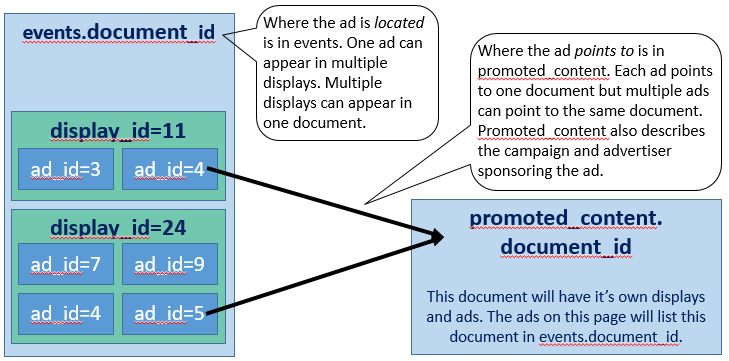

In [13]:
Image(filename='relationship_diagram.png')

Anything interesting about the users in page_views?

In [14]:
print(page_views_og.head())

             uuid  document_id  timestamp platform geo_location traffic_source
0  1fd5f051fba643          120   31905835        1           RS              2
1  8557aa9004be3b          120   32053104        1        VN>44              2
2  c351b277a358f0          120   54013023        1        KR>12              1
3  8205775c5387f9          120   44196592        1        IN>16              2
4  9cb0ccd8458371          120   65817371        1    US>CA>807              2


Notice that clicks are not mentioned here. This indicates page_views is about _any_ page view, not just the ones with a 'success' of a click. Hence the full page_views file is 100GB - there were a lot of documents viewed that never received a click.

## Data joining

Now that we know what we have, it's time to join the data to create a consolidated dataframe that we can use for machine learning. The relationships are complicated due to potential multiple joins and document_id having two different definitions depending on which table it comes from. Therefore, we join tables in a step-wise fashion, checking that the key field per tale is included as we build up our working dataset. Please see inline comments for what happens at each step.

In [6]:
# Documents are highest level item in the dataset.

# To find the full set of documents covered by our datasets, 
# pull in the documents that are in both page_views and promoted_content.
# We do this because page_views_sample is only a sample of all the page_views (full dataset is 2 billion rows, 100GB)
# and if we try to find the page_views that are associated with our clicks_train (in the intuitive order), we won't
# be able to find all the page_views because it's only a sample. 

# Therefore, we 'reverse engineer' our datasets so that we make sure we grab the information that we CAN get from 
# our sample, mini datasets.

doc_ids = set(page_views_og['document_id']) & set(promoted_content_og['document_id'])

# To only view displays and ads that are on our 'master' document list,
# filter events to documents that are found in page_views and promoted_content.
events = events_og[events_og['document_id'].isin(doc_ids)]

# We only want to view ad clicks for displays that have document information.
# So we filter clicks to displays found in events.
clicks_train = clicks_train_og[clicks_train_og['display_id'].isin(events['display_id'])]

# Because clicks may not cover all displays shown in events,
# re-filter events to display_id's that are found in clicks_train.
events = events_og[events_og['display_id'].isin(clicks_train['display_id'])]

# By this point we have a solid list of ads, displays, and documents found in our activity files.
# Now filter promoted content to ads found in the filtered training dataset for model fitting.
promoted_content = promoted_content_og[promoted_content_og['ad_id'].isin(clicks_train['ad_id'])]

# We only need document information about documents we are still considering after prior filters.
# Filter document content files to only documents that have made it through to promoted_content for space reasons.
doc_cats = doc_cats_og[doc_cats_og['document_id'].isin(promoted_content['document_id'])]
doc_ents = doc_ents_og[doc_ents_og['document_id'].isin(promoted_content['document_id'])]
doc_meta = doc_meta_og[doc_meta_og['document_id'].isin(promoted_content['document_id'])]
doc_topics = doc_topics_og[doc_topics_og['document_id'].isin(promoted_content['document_id'])]

# Similarly, filter page views to documents found in events to make this file manageable.
# Since we already filtered based on this file in the beginning, this is re-filtering just to get only the data we need
page_views = page_views_og[page_views_og['document_id'].isin(events['document_id'])]

# Running into a lot of memory errors, so we try to remove all objects that are unnecessary after use
del doc_ids

# Data Transformation

Based on our EDA, we are planning to fit a few models, score them on some basic runs, and then optimize the best performing models. First we will create a large feature space, feature engineer some new variables based on EDA and what features we think will be useful.

## Transforming the training dataset

We are predicting on the central data provided through clicks_train, which has a display, the ads in the display, and which ad was clicked. We want to know as much information as possible about the display and the ad, so we start pulling in data from all the other files.

First we will pull in information about what display a user saw when they clicked. Events will provide information on what happened at a click event.

In [7]:
data = clicks_train.merge(events, on='display_id', how='left')

Next we want to know more about the ads seen. Remeber: a document can contain multiple displays. In every display, there are multiple ads presented. The document containing the displays will be called document_id_x. Which document the ad is promoting (the document you're taken to when when clicking on the ad) will be document_id_y. Think source (x) and destination (y) documents. All the columns after document_id_y are information about the promoted document.

In [8]:
data = data.merge(promoted_content, on='ad_id', how='left')

Now that we have meta data about the ads, we need to know more about the promoted document content - what that ad is pointing to. We gather this in the document_X csv's. As noted above, the confidence level deteremines how likely the listed category or topic is actually related to the document.

We wanted to duplicate the idea of the CountVectorizer for the 'bag of words' model we used for spam detection, but since we're not counting words in a text, it's a little bit different. We have a 'dictionary' of categories and topics that we use as our 'vocabulary.' Every document has a confidence level for one or more items in the vocabulary. We create a sparse matrix with every topic and category as columns, and every document's associated confidence level value in the respective columns. If the document is not not given a confidence level, we put assume a 0 confidence meaning Outbrain believes the document is unrelated to that category or top.

This data on the documents will help us separate ads from one another based on topic/category. For example, why did ad A get clicked instead of ad B? We know ad A referred to document 1 whereas ad B referred to document 2, and now we have general information about the documents the ads referred to. We will merge this information in later steps.

In [9]:
# promoted document topics
sparsetop = doc_topics.pivot(index='document_id', columns='topic_id', values='confidence_level')
sparsetop.columns = ['top_' + str(col) for col in sparsetop.columns]

# promoted document categories
sparsecat = doc_cats.pivot(index='document_id', columns='category_id', values='confidence_level')
sparsecat.columns = ['cat_' + str(col) for col in sparsecat.columns]

# join together the topics and categories
sparse = sparsetop.join(sparsecat, how='outer')
sparse.fillna(0, inplace=True)

# remove the separate files to save space but keep the combined file for use with click_teset
del sparsetop, sparsecat

sparse.reset_index(level=0, inplace=True)

# merge in combined category/topics file with data - greatly increases number of columns
data = data.merge(sparse, left_on='document_id_y', right_on='document_id', how='left')

We know ads are a product of their advertiser, their overall campaign, and the document where they are seen. So we'll add some meta data about how successful the advertiser has been with clicks previously, how successful the campagin has been with clicks previously, and how frequently the document where the ad was seen has been viewed.

In [10]:
# advertiser success information dictionary -- keep for use with click_teset
advr_success = dict(zip(data.advertiser_id.unique(),
                        [sum(data[data['advertiser_id']==x]['clicked'])/len(data[data['advertiser_id']==x]) for x in data['advertiser_id'].unique()]))
# add advertiser success into dataset
data['advertiser_perc'] = data['advertiser_id'].map(advr_success)

# campagin success information dictionary -- keep for use with click_teset
camp_success = dict(zip(data.campaign_id.unique(), 
                        [sum(data[data['campaign_id']==x]['clicked'])/len(data[data['campaign_id']==x]) for x in data['campaign_id'].unique()]))
# add campaign success into dataset
data['campaign_perc'] = data['campaign_id'].map(camp_success)

# document view frequencies -- keep for use with click_teset
doc_view_freq = dict(zip(page_views.document_id.unique(), 
                         [len(page_views[page_views.document_id==x]) for x in page_views.document_id.unique()]))
# add document view frequency into dataset
data['docx_view_freq'] = data['document_id_x'].map(doc_view_freq)

Finally, an ad that has been clicked previously is more likely to be clicked again since many people have similar interests. So we'll conclude our dataset by adding a probability that an ad as been previously clicked given how often it's been clicked. This becomes a little try for an ad that has been viewed infrequently, if ever. To account for this, we add regularization with the following two steps:

1. if the ad has not been seen before, assign it the mean probability that any ad will be clicked
2. for ads that have been seen, add 1 to their click counts and 10 to their total seen counts

These two steps will keep an ad that was seen only once from being a 100% or 0% click success.

In [11]:
def click_percent(dataset, ad_id, default_result, reg):
    '''Returns the posterior probability of ad being clicked.
    If ad has not been encountered before, assume mean click'''
    
    # count number of times ad has been seen
    ad_total = len(dataset[dataset['ad_id'] == ad_id])
    
    # if ad has not been seen, returned the default_results
    if ad_total == 0:
        return default_result
    # otherwise return percentage of times ad has been clicked, adjusted by a regularization term
    else:
        click_sum = np.sum(dataset[dataset['ad_id'] == ad_id].clicked) + 1.0
        return click_sum / (ad_total + reg)

    
# calculate mean times any ad has been clicked
mean_click = np.mean(data["clicked"])

# click posterior frequencies -- keep for use with click_teset
click_success = dict(zip(data.ad_id.unique(), 
                         [click_percent(data, x, mean_click, 10.0) for x in data["ad_id"].unique()] ))
# add click frequency into dataset
data['click_perc'] = data['ad_id'].map(click_success)

del mean_click

## Formatting testing dataset

When dealing with the testing dataset (click_test), we have to be careful not to delete any of the original 330M rows (which equates to 6.2M unique display_ids). This has proved challenging throughout development both from an organization standpoint (making sure we don't accidentally filter out rows) and a size standpoint (330M rows is larger than our little laptops can comfortably handle). 

Further, we discovered, after much upset, that one of the 200ish categories is in the training dataset but not in the testing dataset. This resulted in our final testing dataset having a different number of columns from the training dataset and angered our ML algorithms. To solve for this issue, we have gathered the basic information about the testing data by joining on events and promoted_content (similar to the start of the training dataset). We pull in the other information later (see below under modeling).

In [12]:
# Pull from full events_og to make sure all display information is gathered
data_test = clicks_test_og.merge(events_og, on='display_id', how='left')

# find the ads from the entire promoted_content_og data and not the one filtered on clicks_train
data_test = data_test.merge(promoted_content_og, on='ad_id', how='left')

## Splitting training into train and development

In [13]:
def split_train_dev(dataset, train_percent = 0.7):
    '''Splitting data into test and dev.
    If train_precent is left at default, 70% will go into training and 30% into development.
    If train_percent = 1, all data will go into training.
    If train_percent = 0, all data will go into development.'''

    labels = data['clicked']
    labels = labels.values.reshape(-1,1)

    print ('Labels length:', len(labels))
    print ('data length:', data.shape)
    print ('')
        
    train_data = data[:int(train_percent*len(data))].drop('clicked', 1)
    dev_data = data[int(train_percent*len(data)):].drop('clicked', 1)

    train_labels = labels[:int(train_percent*len(data))]
    dev_labels = labels[int(train_percent*len(data)):]

    print ('training label shape:', train_labels.shape)
    print ('training data shape:', train_data.shape)
    print ('dev label shape:', dev_labels.shape)
    print ('dev data shape:', dev_data.shape)
    
    return train_data, train_labels, dev_data, dev_labels

train_data, train_labels, dev_data, dev_labels = split_train_dev(data, train_percent = 0.7)

Labels length: 282205
data length: (282205, 411)

training label shape: (197543, 1)
training data shape: (197543, 410)
dev label shape: (84662, 1)
dev data shape: (84662, 410)


So now we have three datasets
1. train_data, train_labels = 70% of clicks_train dataset. Used for training models.
2. dev_data, dev_labels = remaining 30% of clicks_train dataset. Used for measuring accuracy of models on non-train data.
3. test_data = clicks_test dataset for final scoring of model.

In [23]:
# to print any of these datasets to csv, uncomment the appropriate line

# data_test.to_csv('testingdata.cvs',index=False)
# data.to_csv('fulltrainingdata.cvs',index=False)
# train_data.to_csv('trainingdata.cvs',index=False)
# train_labels.to_csv('traininglabels.cvs',index=False)
# dev_data.to_csv('developmentdata.cvs',index=False)
# dev_labels.to_csv('developmentlabels.cvs',index=False)

# And finally, onto the modeling

Now that we have the datasets in a starting state, we can delete some of the original raw tables to save memory.

In [14]:
del doc_cats, doc_ents, doc_meta, doc_topics, promoted_content, events, page_views
del clicks_train_og, promoted_content_og, doc_cats_og, doc_ents_og, doc_meta_og, doc_topics_og, events_og, page_views_og, clicks_test_og

## Logistic Regression

Here we will do some basic EDA to look at the distribution of some of our more promising variables.

Considering we have a binary response (clicked or not clicked), we cannot do linear regression which has a continuous response. Our binary response variable violates linearity and thus logistic regression allows us to perform regression on several continuous variables by applying a transformation. Logistic regression also does not require a linear relationship between the dependent and response variables, which we clearly do not have (given the binary response).

There are several assumptions logistic regression makes, so we will check these assumptions below:

0.873513596321
0.000134479244919
0.00135907055519
-0.000873503139683
0.00804353280574
0.00742910573347
0.833924463347 -- high correlation
0.816412120579 -- high correlation
0.0830370838471


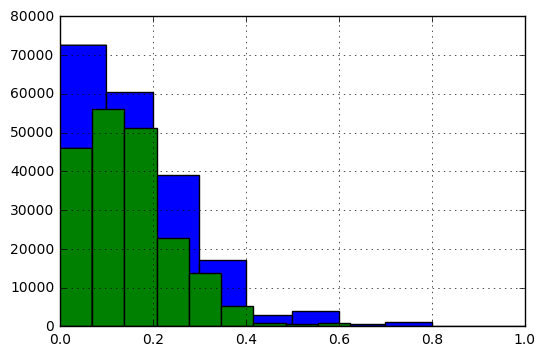

In [73]:
%matplotlib inline

# Multicollinearity
print(train_data['click_perc'].corr(train_data['campaign_perc']))
print(train_data['cat_1000'].corr(train_data['cat_1210']))
print(train_data['top_200'].corr(train_data['cat_1210']))
print(train_data['cat_1000'].corr(train_data['top_130']))
print(train_data['cat_1000'].corr(train_data['campaign_perc']))
print(train_data['cat_1000'].corr(train_data['click_perc']))
print(train_data['advertiser_perc'].corr(train_data['campaign_perc']), '-- high correlation')
print(train_data['advertiser_perc'].corr(train_data['click_perc']), '-- high correlation')
print(train_data['advertiser_perc'].corr(train_data['docx_view_freq']))

# there are some higher correlations between advertiser_perc, campaign_perc, and click_perc which make sense
# because advertisers have their own campaigns and each advertisement belongs to an advertiser and a campaign
# so we choose one instead of the three that are correlated (advertiser_perc, campaign_perc, click_perc)
# we will try our regression taking out the collinear variables


# Normality
train_data['advertiser_perc'].hist()
np.log1p(train_data['advertiser_perc']).hist()
# transformation didn't make that much more normal, but normality is a weaker assumption that doesn't have to be fulfilled...


# Independence of errors




In [ ]:
# clicks_test is too large to run (over 6M rows breaks my poor computer's memory) so we're doing it in batches

def lr_output(dataset, model):
    
    # matching top_X and cat_X categories from training to test. Sparse was created while developing the training dataset.
    dataset = dataset.merge(sparse, left_on='document_id_y', right_on='document_id', how='left')
    
    # Adding meta data from training
    dataset['docx_view_freq'] = dataset['document_id_x'].map(doc_view_freq)
    dataset['campaign_perc'] = dataset['campaign_id'].map(camp_success)
    dataset['advertiser_perc'] = dataset['advertiser_id'].map(advr_success)
    dataset['click_perc'] = dataset['ad_id'].map(click_success)
    
    # fill any nas so the modeling won't get wonky
    dataset.fillna(0, inplace=True)
    
    # check if there are any missing columns between the two datasets
    if set(dataset.columns) ^ set(train_data.columns) :
        print('We have a problem here!')
        
    click_prob = pd.DataFrame({'display_id': dataset['display_id'],
                               'ad_id': dataset['ad_id'],
                               'prediction': lr.predict_proba(dataset[dataset.columns[11:]].fillna(0))[:,1]
                              })
    
    return click_prob

lr = LogisticRegression()
lr.fit(train_data[train_data.columns[11:]].fillna(0), train_labels)

lr_click_probs = pd.DataFrame({'display_id': [], 
                               'ad_id': [], 
                               'prediction': []})
display_ids = data_test.display_id.unique()
min_id, max_id, display_max = 0, 100000, len(display_ids)

while min_id != display_max:

    # keep index within length of display_ids
    max_id = min(max_id,display_max)
    
    # grab that subset of idsplay_ids
    display_subset = display_ids[min_id:max_id]
    
    # find the subset
    print('starting with', min_id, max_id)
    output = lr_output(data_test[data_test.display_id.isin(display_subset)], lr)
    print('output', output.shape)
    lr_click_probs = lr_click_probs.append(output, ignore_index = True)
    
    print('finished with', lr_click_probs.shape)
    min_id = max_id
    max_id += 100000

print(lr_click_probs.shape)

C:\Users\lisam\Anaconda2\envs\py35\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


starting with 0 100000
output (514114, 3)
finished with (514114, 3)
starting with 100000 200000
output (524890, 3)
finished with (1039004, 3)
starting with 200000 300000
output (511203, 3)
finished with (1550207, 3)
starting with 300000 400000
output (517584, 3)
finished with (2067791, 3)
starting with 400000 500000
output (514534, 3)
finished with (2582325, 3)
starting with 500000 600000
output (513592, 3)
finished with (3095917, 3)
starting with 600000 700000
output (521877, 3)
finished with (3617794, 3)
starting with 700000 800000
output (511417, 3)
finished with (4129211, 3)
starting with 800000 900000
output (521235, 3)
finished with (4650446, 3)
starting with 900000 1000000
output (507411, 3)
finished with (5157857, 3)
starting with 1000000 1100000
output (511411, 3)
finished with (5669268, 3)
starting with 1100000 1200000
output (510785, 3)
finished with (6180053, 3)
starting with 1200000 1300000
output (508638, 3)
finished with (6688691, 3)
starting with 1300000 1400000
output 

KeyboardInterrupt: 

In [ ]:
# sort predictions
lr_click_probs.sort_values(by=['display_id','prediction'], ascending=False, inplace=True)

# Format the data the way the submission requires
output=lr_click_probs.groupby(['display_id'])['ad_id'].apply(lambda x:' '.join(map(str,x))).reset_index()

# That's it for the simple solution (prior expectation)!
output.to_csv('submission_20161211_1644.cvs',index=False)

# SVD stuff goes below this cell

# SVD stuff goes above this cell

# Decision Tree stuff goes below this cell

# Decision Tree stuff goes above this cell

# K-Nearest Neighbor

We tried this as a very basic model to see if we could get a good prediction from just similarities of rows. Perhaps certain advertisers, certain topics, certain ads just did better overall irregardless of unnecessarily complicated variables.

In [ ]:
from sklearn.metrics import classification_report


kmeans_train = train_data.fillna(0)
kmeans_dev = dev_data.fillna(0)

def kmeans(k_values):

    for i in k_values:
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(kmeans_train[kmeans_train.columns[11:]], train_labels)
        preds = neigh.predict(kmeans_dev[kmeans_dev.columns[11:]])
        print("k=",i,":",classification_report(dev_labels, preds))

k_values = [1, 3, 5]
kmeans(k_values)

# k=1 is overfitting to the training set completely, and yet the prediction accuracy is still very low.
# the recall and precision of predicting an ad that was clicked (1) is extremeley low even with overfitting,
# so with more generalization and higher k-values, we don't expect much better.

# try again but only with the engineered variables of clicks, not including category/topic

def kmeans2(k_values):

    for i in k_values:
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(kmeans_train[kmeans_train.columns[406:]], train_labels)
        preds = neigh.predict(kmeans_dev[kmeans_dev.columns[406:]])
        print("k=",i,":",classification_report(dev_labels, preds))

k_values = [1, 3, 5]
kmeans2(k_values)

# even running on the last 4 columns, feature engineered to look at overall averages of clicks based on 
# other features like advertiser, campaign do not result in good accuracies

In [ ]:
# try binarizing platform & advertiser_id as more features for kmeans
# kmeans finds similar neighbors, calculates dissimilarity distances between rows
# so more differentiating factors can help kmeans find 'similar' neighbors for prediction
# advertiser and platform may be good features that differentiate clicks

# advertiser may take a while and kill the kernel, so feel free to keep it commented out

#advertiser = pd.get_dummies(train_data, columns={'advertiser_id'}, prefix="advertiser")
platform = pd.get_dummies(kmeans_train, columns={'platform'}, prefix="platform")
train_data_kmeans = platform[platform.columns[:1].union(platform.columns[405:])]
#train_data_kmeans = train_data_kmeans.merge(advertiser[advertiser.columns[:1].union(advertiser.columns[409:])], on='display_id')
del train_data_kmeans["display_id"]

#advertiser_dev = pd.get_dummies(dev_data, columns={'advertiser_id'}, prefix="advertiser")
platform_dev = pd.get_dummies(kmeans_dev, columns={'platform'}, prefix="platform")
dev_data_kmeans = platform_dev[platform_dev.columns[:1].union(platform_dev.columns[405:])]
#dev_data_kmeans = dev_data_kmeans.merge(advertiser_dev[advertiser_dev.columns[:1].union(advertiser_dev.columns[409:])], on='display_id')
del dev_data_kmeans["display_id"]

def kmeans3(k_values):

    for i in k_values:
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(train_data_kmeans, train_labels)
        preds = neigh.predict(dev_data_kmeans)
        print("k=",i,":",classification_report(dev_labels, preds))

k_values = [1, 3, 5]
kmeans3(k_values)

Kmeans did not do a good job of predicting the correct "clicked" ads. It did get slightly better with more features, but even with K=1, the recall and precision of class 1 (clicked) was ~20% which is terrible for what is supposed to be the most overfitted you can get in kmeans. 

# Jay's magic goes below this cell

# Jay's magic goes above this clel

# Appendix/Working space - this is stuff that hasn't been added to the 'full' run.
### AKA Lisa's stuff that might go somewhere or might be dumped.

### Lost comments
** The below are all good comments that have become detached from their original location, probably from Lisa creating the dataload.py. Keeping them here for now so that they can be reattached as we work on formating the final notebook.**

---

### Merge information about the documents the ads refer to
---

creating dictionaries for % of ads clicked for every advertiser and campaign.  
purpose: merge to master dataset as a feature for every ad, how often the advertiser and campaign are successful on average.

---

Add count of page views to every document that an ad appears in (document_id_x) as a feature, could tell us something about likelihood of ads being clicked

In [ ]:
# #################3 IGNORE THIS#############3

# # events['country'], events['state'] = zip(*map(lambda x: str(x).split('>'), list(events['geo_location'])))

# # #temp = map(lambda x: str(x).split('>'), list(page_views['geo_location']))
# # print temp[:5]
# # zip(*temp[:5]) # removes DMA

# #events2 = pd.DataFrame(events['geo_location'].str.split(',').tolist(), columns = ['country', 'state', 'dma'])
# events['geo_location'].str.split('>', expand= True)
# geo = map(lambda x: str(x).split('>'), events['geo_location'])
# zip(*geo)
# country = [x[0] for x in geo]
# #state = [x[1] for x in geo if x[1]]
# if None:
#     print('a')

In [ ]:
def lr_prediction(train_data, train_labels, test_data, test_labels):
    '''Returns the array of display_id, ad_id and probability it will be clicked'''
    lr = LogisticRegression()
    lr.fit(train_data[train_data.columns[11:]].fillna(0), train_labels)
    lr_click_prob = lr.predict_proba(test_data[test_data.columns[11:]].fillna(0))[:,1]
    lr_score = lr.score(test_data[test_data.columns[11:]].fillna(0), test_labels)
    return pd.DataFrame({'display_id': test_data['display_id'],
                         'ad_id': test_data['ad_id'],
                         'prediction': lr_click_prob
                        })
lr_output = lr_prediction(train_data, train_labels, dev_data, dev_labels)

In [ ]:
# first, format the training dataset

def click_percent(dataset, ad_id, default_result, reg):
    '''Returns the posterior probability of ad being clicked.
    If ad has not been encountered before, assume mean click'''
    
    # count number of times ad has been seen
    ad_total = len(dataset[dataset['ad_id'] == ad_id])
    
    # if ad has not been seen, returned the default_results
    if ad_total == 0:
        return default_result
    # otherwise return percentage of times ad has been clicked, adjusted by a regularization term
    else:
        click_sum = np.sum(dataset[dataset['ad_id'] == ad_id].clicked) + 1.0
        return click_sum / (ad_total + reg)

# Merging information aout the displays to master dataset
data = clicks_train.merge(events, on='display_id', how='left')
# joins information about the display that the user saw
# each display has a unique user id, doc id, and timestamp
# events has the information about the display (who the user is, which site (document_id) it was on, when it was seen, from where, etc.)

# Identifying which documents the ads refer to (aka destination documents)
data = data.merge(promoted_content, on='ad_id', how='left')
#Now we are merging information on what documents the ads referred to (from source: promoted_content).  
#

# Gather/bin data about the documents the ads refer to
sparsetop = doc_topics.pivot(index='document_id', columns='topic_id', values='confidence_level')
sparsetop.columns = ['top_' + str(col) for col in sparsetop.columns]

sparsecat = doc_cats.pivot(index='document_id', columns='category_id', values='confidence_level')
sparsecat.columns = ['cat_' + str(col) for col in sparsecat.columns]

sparse = sparsetop.join(sparsecat, how='outer')
sparse.fillna(0, inplace=True)
del sparsetop, sparsecat

sparse.reset_index(level=0, inplace=True)

data = data.merge(sparse, left_on='document_id_y', right_on='document_id', how='left')

# adding in advertiser information
advr_success = dict(zip(data.advertiser_id.unique(),
                        [sum(data[data['advertiser_id']==x]['clicked'])/len(data[data['advertiser_id']==x]) for x in data['advertiser_id'].unique()]))
data['advertiser_perc'] = data['advertiser_id'].map(advr_success)

# adding in campagin information
camp_success = dict(zip(data.campaign_id.unique(), 
                        [sum(data[data['campaign_id']==x]['clicked'])/len(data[data['campaign_id']==x]) for x in data['campaign_id'].unique()]))
data['campaign_perc'] = data['campaign_id'].map(camp_success)

# adding in meta about document view frequencies
doc_view_freq = dict(zip(page_views.document_id.unique(), 
                         [len(page_views[page_views.document_id==x]) for x in page_views.document_id.unique()]))
data['docx_view_freq'] = data['document_id_x'].map(doc_view_freq)

# Adding meta data about prior click percentage
mean_click = np.mean(data["clicked"])
click_success = dict(zip(data.ad_id.unique(), 
                         [click_percent(data, x, mean_click, 10.0) for x in data["ad_id"].unique()] ))
data['click_perc'] = data['ad_id'].map(click_success)

print(data.head())